#Visualizing what prompts CLIP finds similar to a CAM masked image
======

##Preliminaries

In [14]:
import matplotlib.pyplot as plt
import numpy as np
import math
import os
import os.path as osp
import clip
import torch
from torchvision import transforms
from PIL import Image
import torch.nn.functional as F
from utils import *


device = "cuda" if torch.cuda.is_available() else "cpu"

# Uncomment the line underneath and comment the line above if you need to hard code the device type
#device = "cuda"   # "cpu"

print("Using device (CUDA recommended for faster processing): ", device)
clip_model, preprocess = clip.load('ViT-B/32', device=device)
clip_model = clip_model.eval()

Using device (CUDA recommended for faster processing):  cuda


##Prompt experiments

Image Name:  2007_000032
Number of classes present:  2
Names of Classes present:  ['aeroplane', 'player']


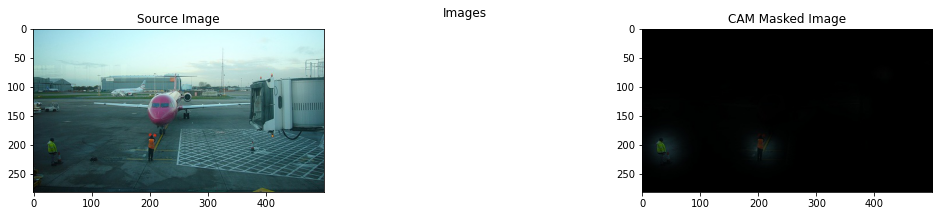

Detected class:  player
List of words:  ['person', 'individual', 'human', 'player']
Softmax similarity scores for each word:  [0.260986328125, 0.0169525146484375, 0.444091796875, 0.27783203125]


<Figure size 432x288 with 0 Axes>

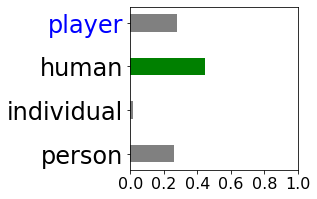

<Figure size 432x288 with 0 Axes>

In [15]:
############ USER INPUTS ####################
test_img_name = "2007_000032"
num = 1
#############################################

# -------------------- Prelim Loading --------------------------------------------------------
contents = os.listdir(osp.join(vis_path, test_img_name))
num_cls = len(prompt_dict[test_img_name.replace("_", "")])
img_path = os.path.join(vis_path, test_img_name, sorted(os.listdir(os.path.join(vis_path, test_img_name)))[num])
source_img_path = os.path.join(dataset_path, test_img_name+".jpg")
class_name = classes[int(sorted(os.listdir(os.path.join(vis_path, test_img_name)))[num][6:-4])]
CLNMS = [classes[int(sorted(os.listdir(os.path.join(vis_path, test_img_name)))[x][6:-4])] for x in range(num_cls)]
# --------------------------------------------------------------------------------------------

print("Image Name: ", test_img_name)
print("Number of classes present: ", num_cls)
print("Names of Classes present: ", CLNMS)

# -------------------- Display Img --------------------------------------------------------
src_img = Image.open(source_img_path)
msk_img = Image.open(img_path)

f, ax = plt.subplots(nrows=1, ncols=2)
f.set_figwidth(20)
f.set_figheight(3)
ax[0].imshow(src_img)
ax[0].set_title("Source Image")
ax[1].imshow(msk_img)
ax[1].set_title("CAM Masked Image")
f.suptitle("Images")
plt.show()
plt.clf()
# ----------------------------------------------------------------------------------------



# -------------------- Generate wordlist --------------------------------------------------------
WD = LOD[0]

word_list = WD[class_name]
word_list = [x.lower() for x in word_list]
if class_name in word_list: 
    word_list.remove(class_name)
    if len(word_list) > 3: word_list= word_list[:3]
    word_list.append(class_name)
else:
    if len(word_list) > 3: word_list = word_list[:3]
    word_list.append(class_name)

#Use the following lines to custom add words
#word_list.remove("")
#word_list.insert(0, "")

# ----------------------------------------------------------------------------------------------

print("Detected class: ", class_name)
print("List of words: ", word_list)

# -------------------- Processing --------------------------------------------------------
prompt_list = [clip.tokenize(f"a photo of a {c}.").to(device)  for c in word_list ] # Control context from this line
img = Image.open(img_path)
img = preprocess(img).unsqueeze(0).to(device)
scores = get_similarity(clip_model, img, prompt_list)
scores = scores[0].detach().cpu().numpy().tolist()
# ----------------------------------------------------------------------------------------

print("Softmax similarity scores for each word: ", scores)



# -------------------- Plot Tools --------------------------------------------------------
f, ax = plt.subplots()
f.set_figwidth(3)
f.set_figheight(3)
COL = ["grey" for pointer in range(len(word_list))]
COL[np.argmax(np.array(scores))] = "green"
ax.barh(word_list, scores, color = COL, height=0.4)

#ax.ylabel("Words")
plt.yticks(fontsize=24)
plt.xticks(fontsize=16)
plt.xlim([0.0,1.0])
ax.get_yticklabels()[-1].set_color("blue")
#plt.xlabel("Similarity")
#plt.title("Softmax sim (Rescam word: {})".format(rescam[test_img_name.replace("_", "")][num]))


plt.show()

#plt.savefig(".\\chosen_ones\\"+test_img_name+"\\class_"+str(num)+"\\"+LOD_names[dnum]+".png", bbox_inches='tight')
plt.clf()
# ----------------------------------------------------------------------------------------